In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/AWEForSegmentation"

In [3]:
!pip install opencv-python-headless matplotlib

In [ ]:
import os

train_folder = "/content/drive/MyDrive/AWEForSegmentation/train"


train_files = sorted(os.listdir(train_folder))
print("Total training images:", len(train_files))
print("First few image files:", train_files[:10])


Total training images: 785
First few image files: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png']


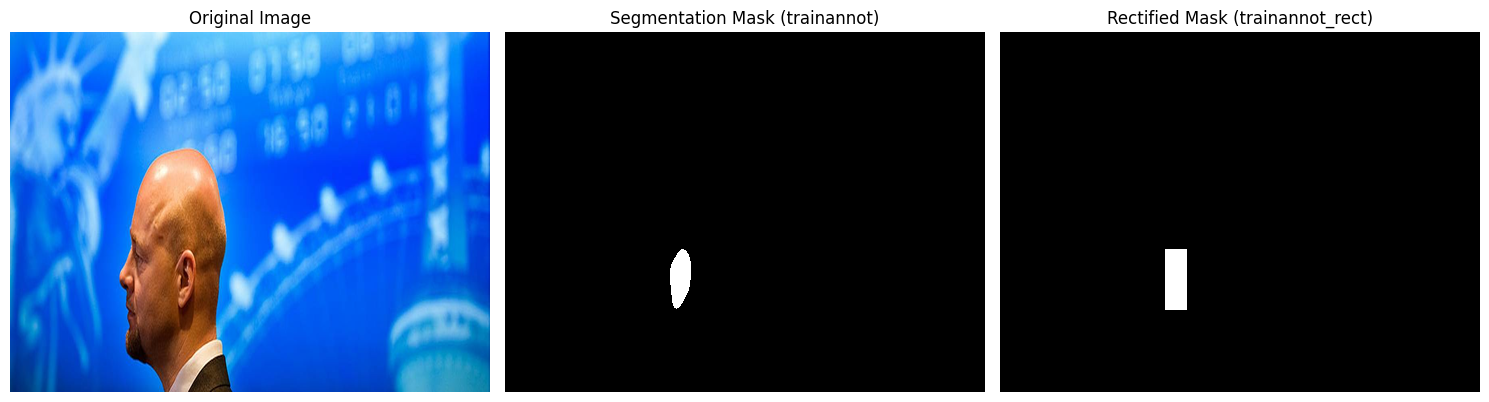

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt


base_path = "/content/drive/MyDrive/AWEForSegmentation"

file_index = 1
file_id = f"{file_index:04d}" 


image_path = os.path.join(base_path, "train", f"{file_id}.png")
mask_path = os.path.join(base_path, "trainannot", f"{file_id}.png")
rect_mask_path = os.path.join(base_path, "trainannot_rect", f"{file_id}.png")


image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
rect_mask = cv2.imread(rect_mask_path, cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Segmentation Mask (trainannot)")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Rectified Mask (trainannot_rect)")
plt.imshow(rect_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
import os
import numpy as np

class EarSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = sorted(os.listdir(image_dir))
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_ids)


    def __getitem__(self, idx):
      image_filename = self.image_ids[idx]
      mask_filename = image_filename.replace('.jpg', '.png').replace('.jpeg', '.png')

      img_path = os.path.join(self.image_dir, image_filename)
      mask_path = os.path.join(self.mask_dir, mask_filename)

      image = cv2.imread(img_path)
      if image is None:
          raise FileNotFoundError(f"Image not found: {img_path}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      if mask is None:
          
          return self.__getitem__((idx + 1) % len(self))

      # Resize
      image = cv2.resize(image, self.image_size)
      mask = cv2.resize(mask, self.image_size)

      # Normalize
      image = image / 255.0
      mask = (mask > 0).astype(np.float32)

      # To tensors
      image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
      mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

      return image, mask


In [ ]:
from torch.utils.data import DataLoader


image_dir = "/content/drive/MyDrive/AWEForSegmentation/train"
mask_dir = "/content/drive/MyDrive/AWEForSegmentation/trainannot"


train_dataset = EarSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir)



train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


sample_img, sample_mask = train_dataset[0]
print("Image shape:", sample_img.shape)
print("Mask shape:", sample_mask.shape)

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


In [13]:
!pip install segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import segmentation_models_pytorch as smp


In [ ]:
# Binary segmentation
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",    
    in_channels=3,
    classes=1,
    activation=None               
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [24]:
loss_fn = nn.BCEWithLogitsLoss()  # Combines sigmoid + binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [25]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0

    for images, masks in tqdm(loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [39]:
num_epochs = 7

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")


100%|██████████| 393/393 [17:57<00:00,  2.74s/it]


Epoch 1/7, Loss: 0.1566


100%|██████████| 393/393 [15:59<00:00,  2.44s/it]


Epoch 2/7, Loss: 0.0571


100%|██████████| 393/393 [16:00<00:00,  2.44s/it]


Epoch 3/7, Loss: 0.0298


100%|██████████| 393/393 [16:14<00:00,  2.48s/it]


Epoch 4/7, Loss: 0.0182


100%|██████████| 393/393 [16:07<00:00,  2.46s/it]


Epoch 5/7, Loss: 0.0126


100%|██████████| 393/393 [16:03<00:00,  2.45s/it]


Epoch 6/7, Loss: 0.0095


100%|██████████| 393/393 [16:03<00:00,  2.45s/it]

Epoch 7/7, Loss: 0.0071


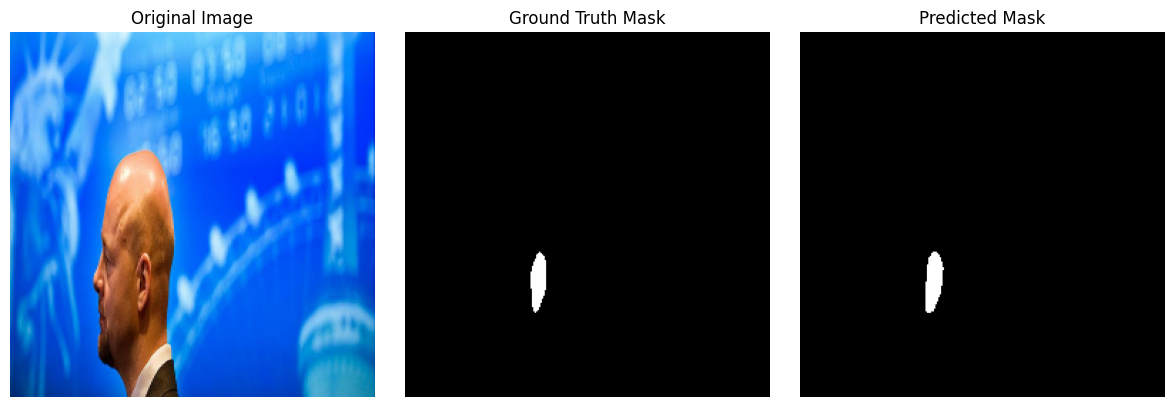

In [ ]:
import matplotlib.pyplot as plt
import torch


model.eval()

# sample image
sample_image, sample_mask = train_dataset[0]  # Change index if needed
input_tensor = sample_image.unsqueeze(0).to(device)


with torch.no_grad():
    pred_mask = model(input_tensor)
    pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask > 0.5, cmap='gray')  # thresholded prediction
plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(int)
    true_bin = true_mask.astype(int)

    intersection = (pred_bin & true_bin).sum()
    union = (pred_bin | true_bin).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union


In [42]:
def calculate_dice(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(int)
    true_bin = true_mask.astype(int)

    intersection = (pred_bin & true_bin).sum()
    return (2. * intersection) / (pred_bin.sum() + true_bin.sum() + 1e-6)


In [43]:
iou = calculate_iou(pred_mask, sample_mask.squeeze().numpy())
dice = calculate_dice(pred_mask, sample_mask.squeeze().numpy())

print(f"IoU Score: {iou:.4f}")
print(f"Dice Score: {dice:.4f}")


IoU Score: 0.8317
Dice Score: 0.9081


In [44]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        smooth = 1.
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice + self.bce(inputs, targets)


In [45]:
loss_fn = DiceBCELoss()


In [46]:
torch.save(model.state_dict(), "ear_seg_model.pth")